In [1]:
# Cheng S et al. A pan-cancer single-cell transcriptional atlas of tumor infiltrating myeloid cells. Cell 2021 
# https://www.sciencedirect.com/science/article/pii/S0092867421000106
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE154763

In [2]:
#!mkdir data
#!mkdir write
#!mkdir figures

In [3]:
import time; start = time.time()

In [4]:
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
#import sc_toolbox.api as sct
import seaborn as sns
import pandas as pd
import scanpy as sc
import numpy as np
sc.logging.print_version_and_date()

Running Scanpy 1.9.1, on 2022-10-08 18:48.


In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [6]:
sc.settings.set_figure_params(scanpy=True, dpi=150, dpi_save=150, color_map='coolwarm',facecolor='white',
                             format='png', transparent=False, frameon=False, vector_friendly=True, fontsize=14)
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.3 scipy==1.7.1 pandas==1.3.4 scikit-learn==0.24.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.6


In [7]:
results_file = './write/pbmc3k.h5ad' # the file that will store the analysis results

In [8]:
adata = sc.read(
    results_file,                  # data file
    var_names='gene_symbols',      # use gene symbols for the variable names (variables-axis index)
    cache=True)                    # write a cache file for faster subsequent reading
adata.uns['log1p']["base"] = None  # Fix " KeyError: 'base' "

In [9]:
adata

AnnData object with n_obs × n_vars = 6254 × 2221
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'connectivities', 'distances'

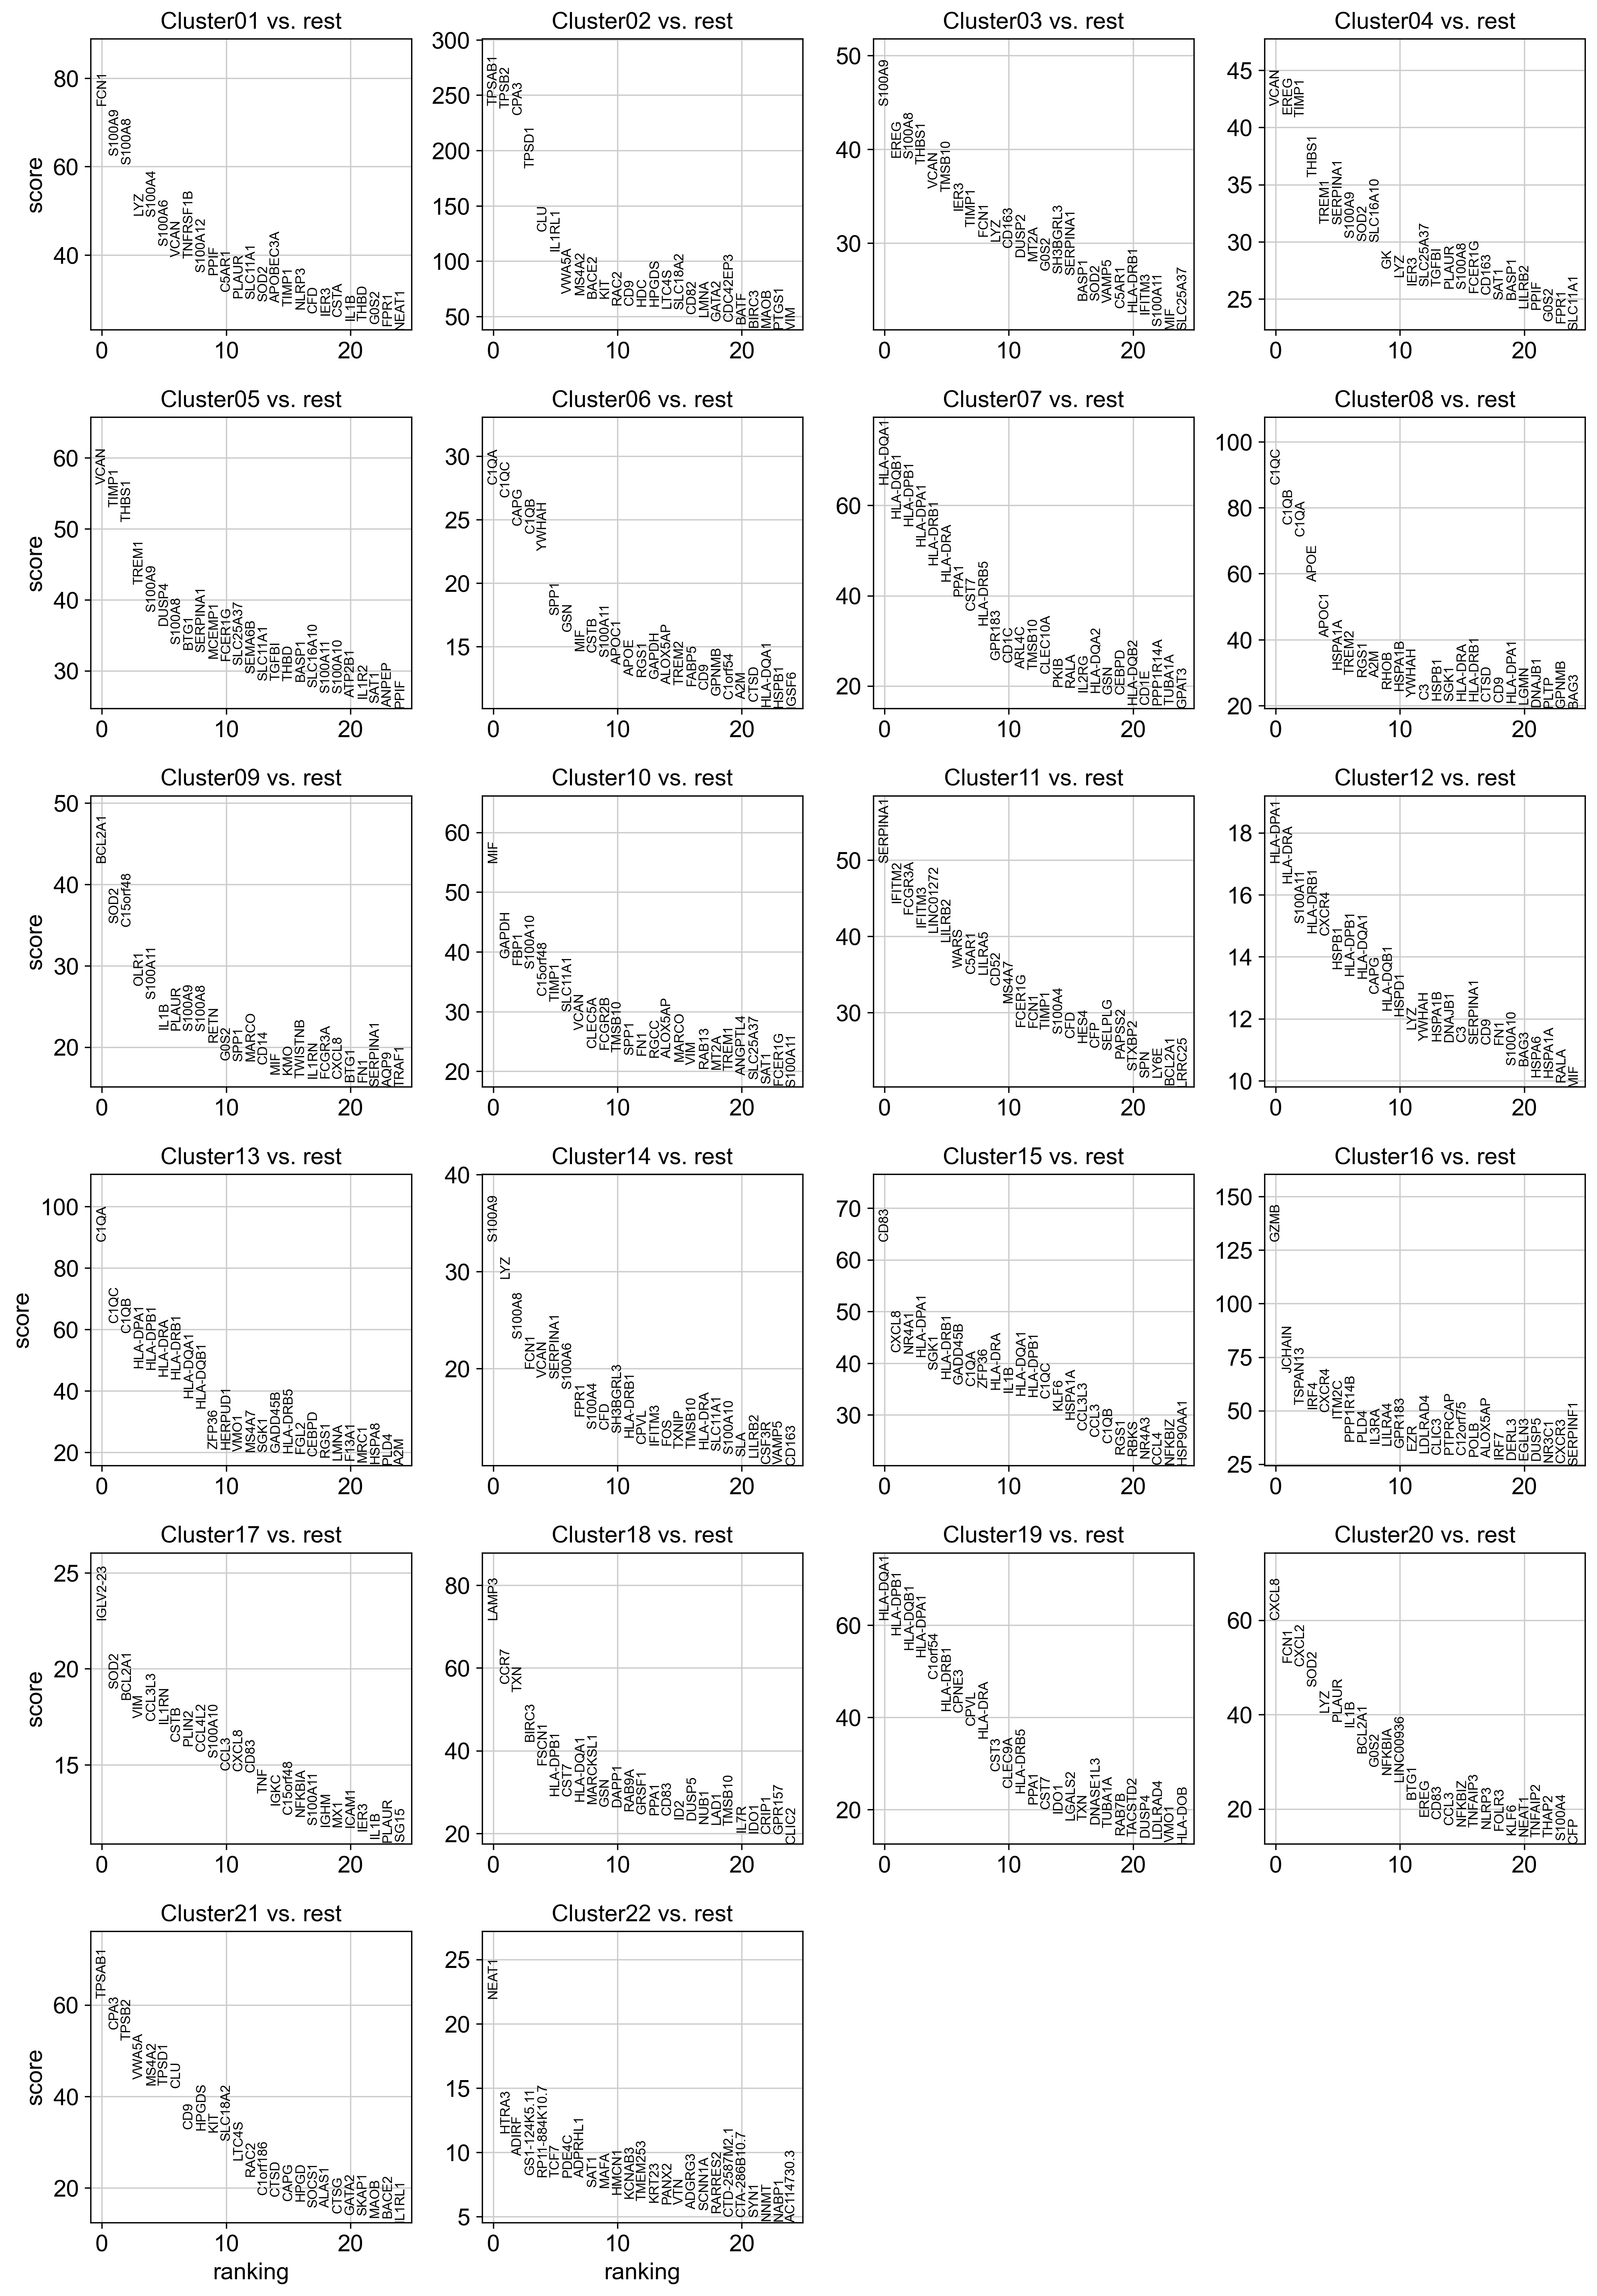

Wall time: 8.83 s


<Figure size 600x600 with 0 Axes>

In [10]:
%%time
# Finding marker genes. Let us compute a ranking for the highly differential genes in each cluster.
# For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before.
# The simplest and fastest method to do so is the t-test.
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test', use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
plt.tight_layout(); plt.savefig("./figures/03a.Ranking_leiden_t-test.png", bbox_inches="tight")

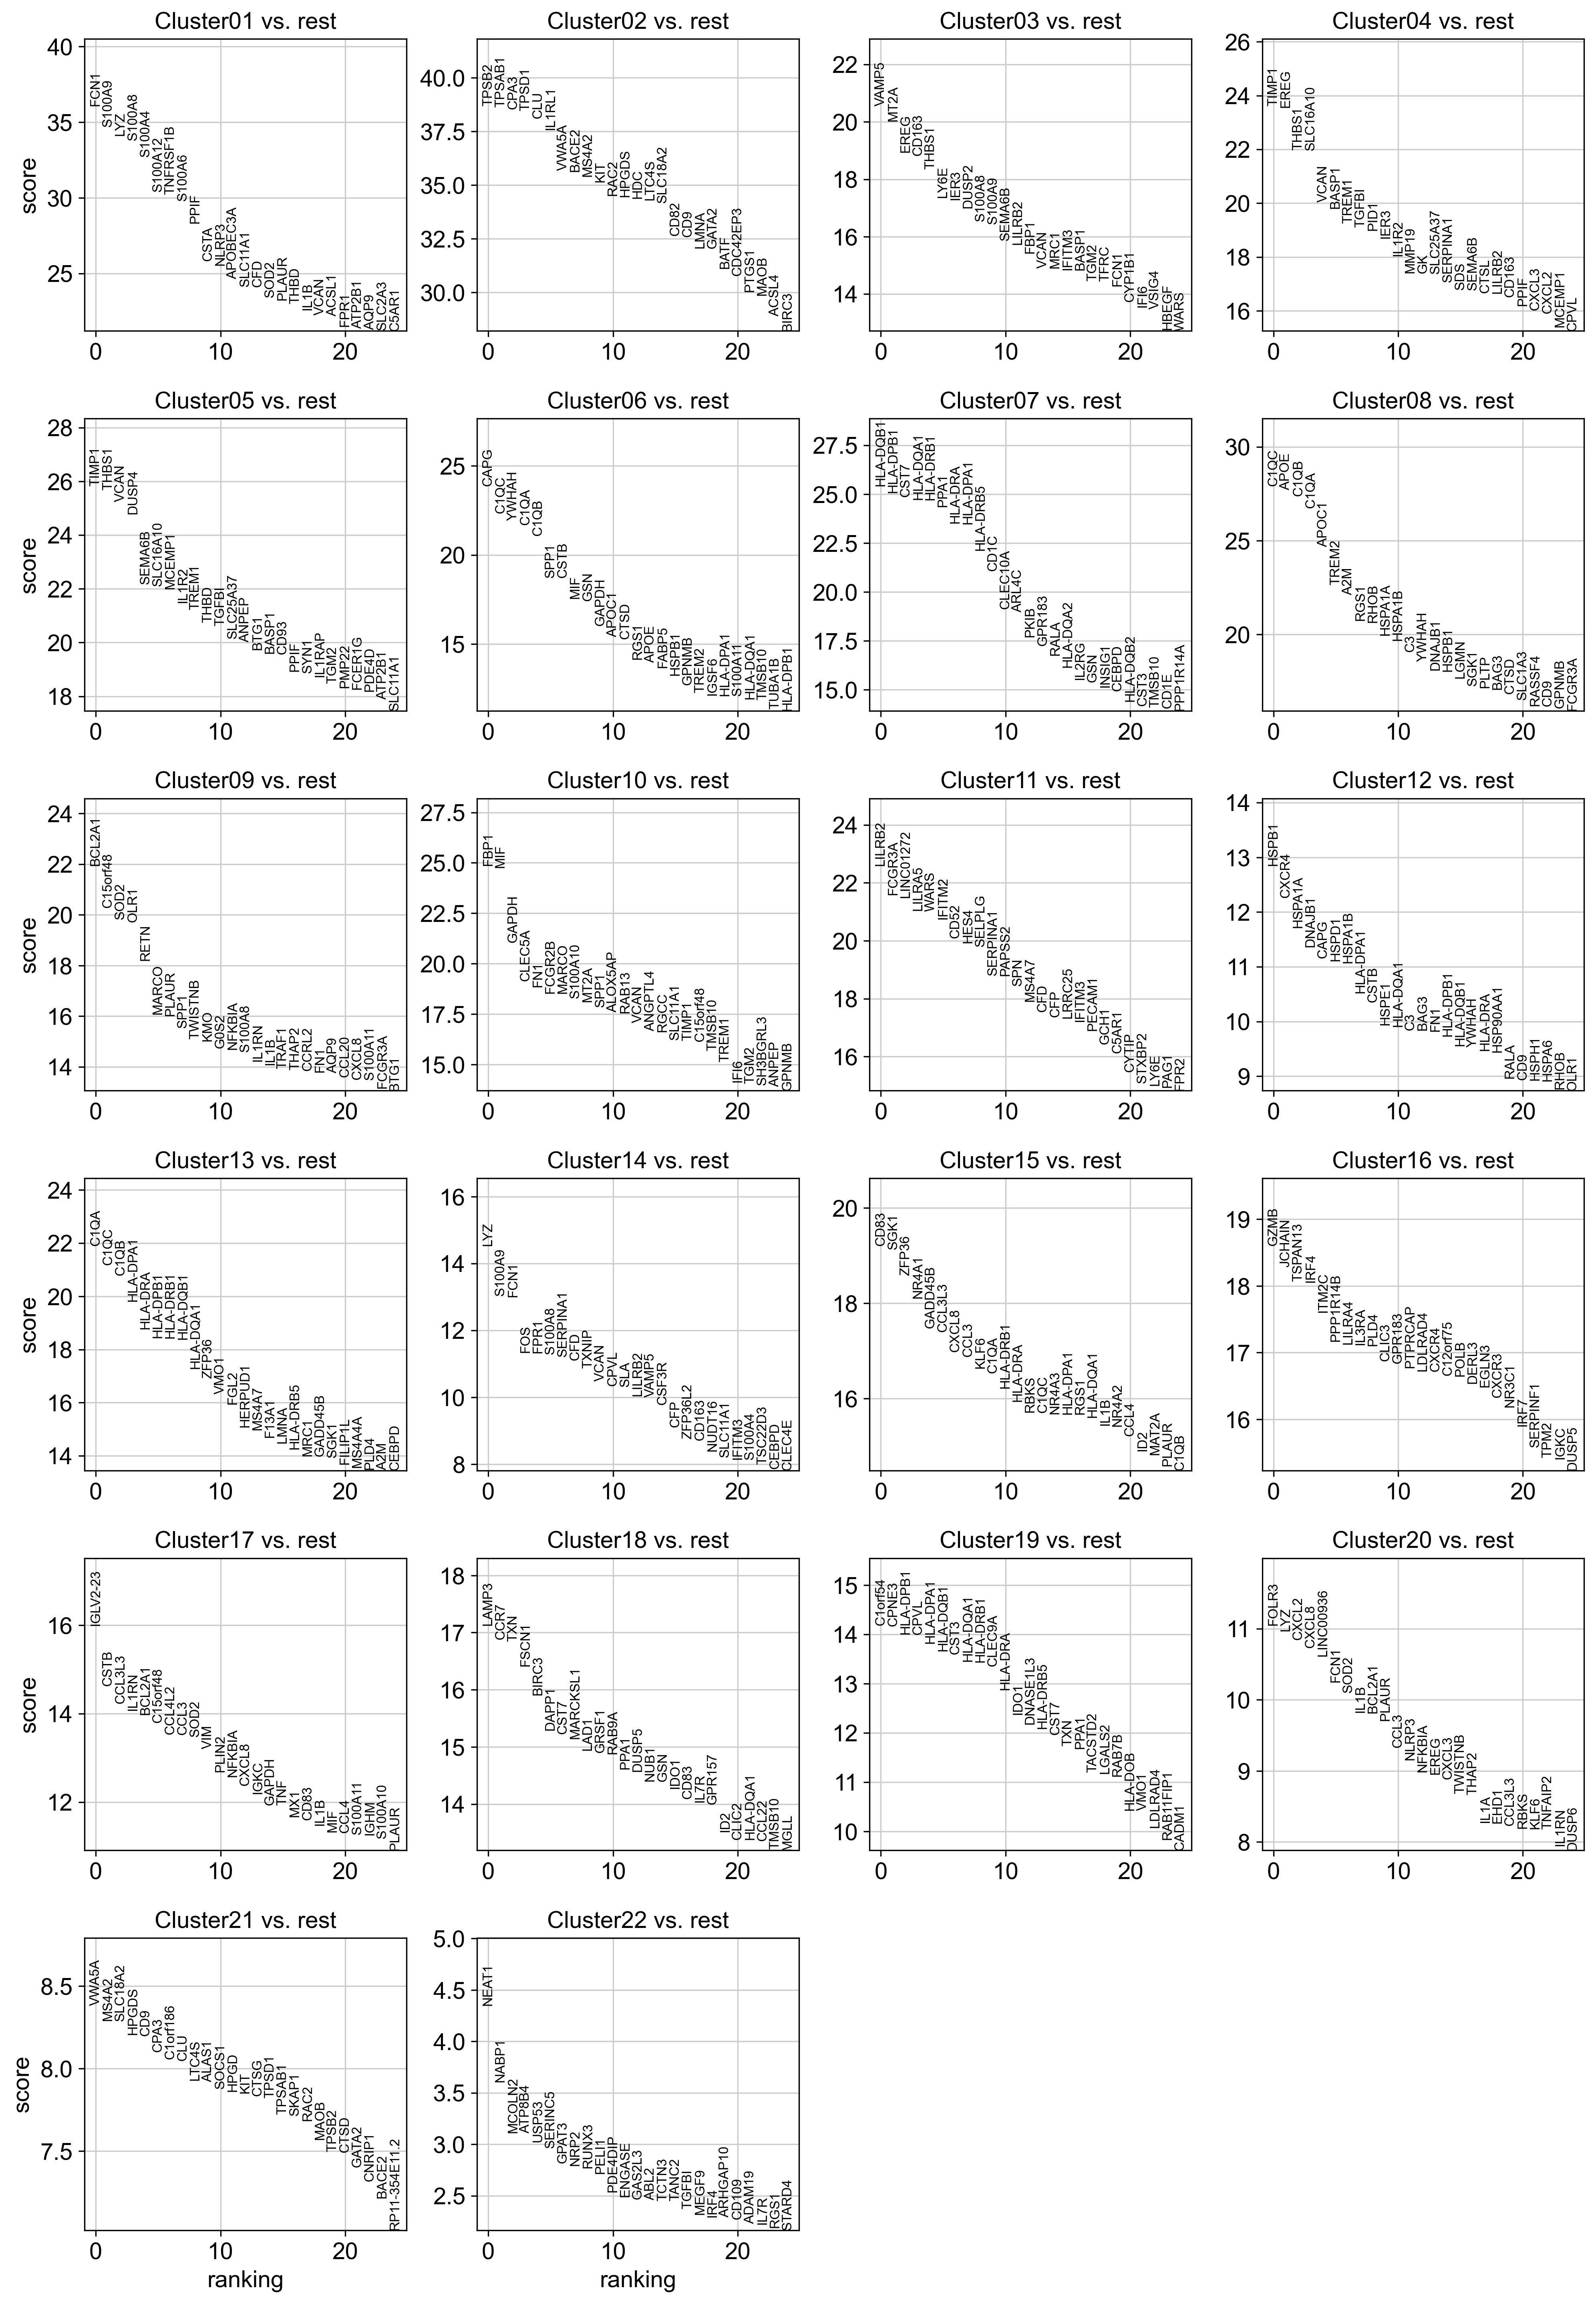

Wall time: 11.4 s


<Figure size 600x600 with 0 Axes>

In [11]:
%%time
# Wilcoxon rank-sum (Mann-Whitney-U test). You might also consider much more powerful differential
# testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
plt.tight_layout(); plt.savefig("./figures/03b.Ranking_leiden_wilcoxon.png", bbox_inches="tight")

In [12]:
# As an alternative, let us rank genes using logistic regression.
#sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [13]:
# Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)  #

Cluster01 Cluster02 Cluster03 Cluster04 Cluster05 Cluster06 Cluster07  \
0      FCN1     TPSB2     VAMP5     TIMP1     TIMP1      CAPG  HLA-DQB1   
1    S100A9    TPSAB1      MT2A      EREG     THBS1      C1QC  HLA-DPB1   
2       LYZ      CPA3      EREG     THBS1      VCAN     YWHAH      CST7   
3    S100A8     TPSD1     CD163  SLC16A10     DUSP4      C1QA  HLA-DQA1   
4    S100A4       CLU     THBS1      VCAN    SEMA6B      C1QB  HLA-DRB1   

  Cluster08 Cluster09 Cluster10  ... Cluster13 Cluster14 Cluster15 Cluster16  \
0      C1QC    BCL2A1      FBP1  ...      C1QA       LYZ      CD83      GZMB   
1      APOE  C15orf48       MIF  ...      C1QC    S100A9      SGK1    JCHAIN   
2      C1QB      SOD2     GAPDH  ...      C1QB      FCN1     ZFP36   TSPAN13   
3      C1QA      OLR1    CLEC5A  ...  HLA-DPA1       FOS     NR4A1      IRF4   
4     APOC1      RETN       FN1  ...   HLA-DRA      FPR1   GADD45B     ITM2C   

  Cluster17 Cluster18 Cluster19  Cluster20 Cluster21 Cluster22  
0  IGLV2-23     LAMP3   C1orf54      FOLR3     VWA5A     NEAT1  
1      CSTB      CCR7     CPNE3        LYZ     MS4A2     NABP1  
2    CCL3L3       TXN  HLA-DPB1      CXCL2   SLC18A2    MCOLN2  
3     IL1RN     FSCN1      CPVL      CXCL8     HPGDS    ATP8B4  
4    BCL2A1     BIRC3  HLA-DPA1  LINC00936       CD9     USP53  

[5 rows x 22 columns]

In [14]:
result = adata.uns["rank_genes_groups"] # Get a table with the scores and groups
groups = result["names"].dtype.names; groups_n = len(groups); print("Total number of clusters: " + str(groups_n))

Total number of clusters: 22


In [15]:
# sc.get.rank_genes_groups_df(adata, group="7")

In [16]:
columns = ["Cluster", "names", "scores", "logfoldchanges", "pvals","pvals_adj"]
df00 = pd.DataFrame(columns = columns) 

for i in groups:
    group = str(i); # print(group) 
    df = sc.get.rank_genes_groups_df(adata, group=group).sort_values("pvals_adj", ascending=True)  
    df['Cluster'] = group; df = df.head(1000)
    df00 = df00.append(pd.DataFrame(df, columns = columns), ignore_index = True)
    df.rename(columns = {'names':'GeneSymbol', 'logfoldchanges':'logFC', 'pvals':'pval',"pvals_adj":'adj_pval'}, inplace=True)
    
print(df00.sample(10))    
df00.to_csv("./write/RankedGenesbyCluster.tsv", sep="\t", index=False)

         Cluster   names    scores  logfoldchanges         pvals  pvals_adj
4702   Cluster05  ADGRE3  1.764265        1.224964  7.768733e-02   0.245439
10317  Cluster11   CLCF1  3.745038        1.576815  1.803662e-04   0.001260
12800  Cluster13  ITGA2B -0.242062       -1.748382  8.087325e-01   0.999926
3873   Cluster04    MREG -1.026389       -4.313076  3.047082e-01   0.774742
15957  Cluster16     SCD -0.875738       -2.169447  3.811725e-01   0.882300
12392  Cluster13   CRADD -2.374451       -2.522355  1.757505e-02   0.099324
17355  Cluster18   ZFP36 -3.615542       -0.458692  2.997199e-04   0.001870
18535  Cluster19    GBP4 -1.552322       -2.064115  1.205853e-01   0.499664
9612   Cluster10  ATP8B4 -1.487170       -1.036728  1.369699e-01   0.495959
6247   Cluster07    CTSC -5.025684       -0.412233  5.016414e-07   0.000004


In [17]:
new_cluster_names = [
    'Cluster01', 'Cluster02', 'Cluster03', 'Cluster04', 'Cluster05',
    'Cluster06', 'Cluster07', 'Cluster08', 'Cluster09', 'Cluster10',
    'Cluster11', 'Cluster12', 'Cluster13', 'Cluster14', 'Cluster15',
    'Cluster16', 'Cluster17', 'Cluster18', 'Cluster19', 'Cluster20',   
    'Cluster21', 'Cluster22', 
]

In [18]:
adata.rename_categories('leiden', new_cluster_names) # Actually mark the cell types.

In [19]:
adata

AnnData object with n_obs × n_vars = 6254 × 2221
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'connectivities', 'distances'

In [20]:
adata.write(results_file) # Save the result.

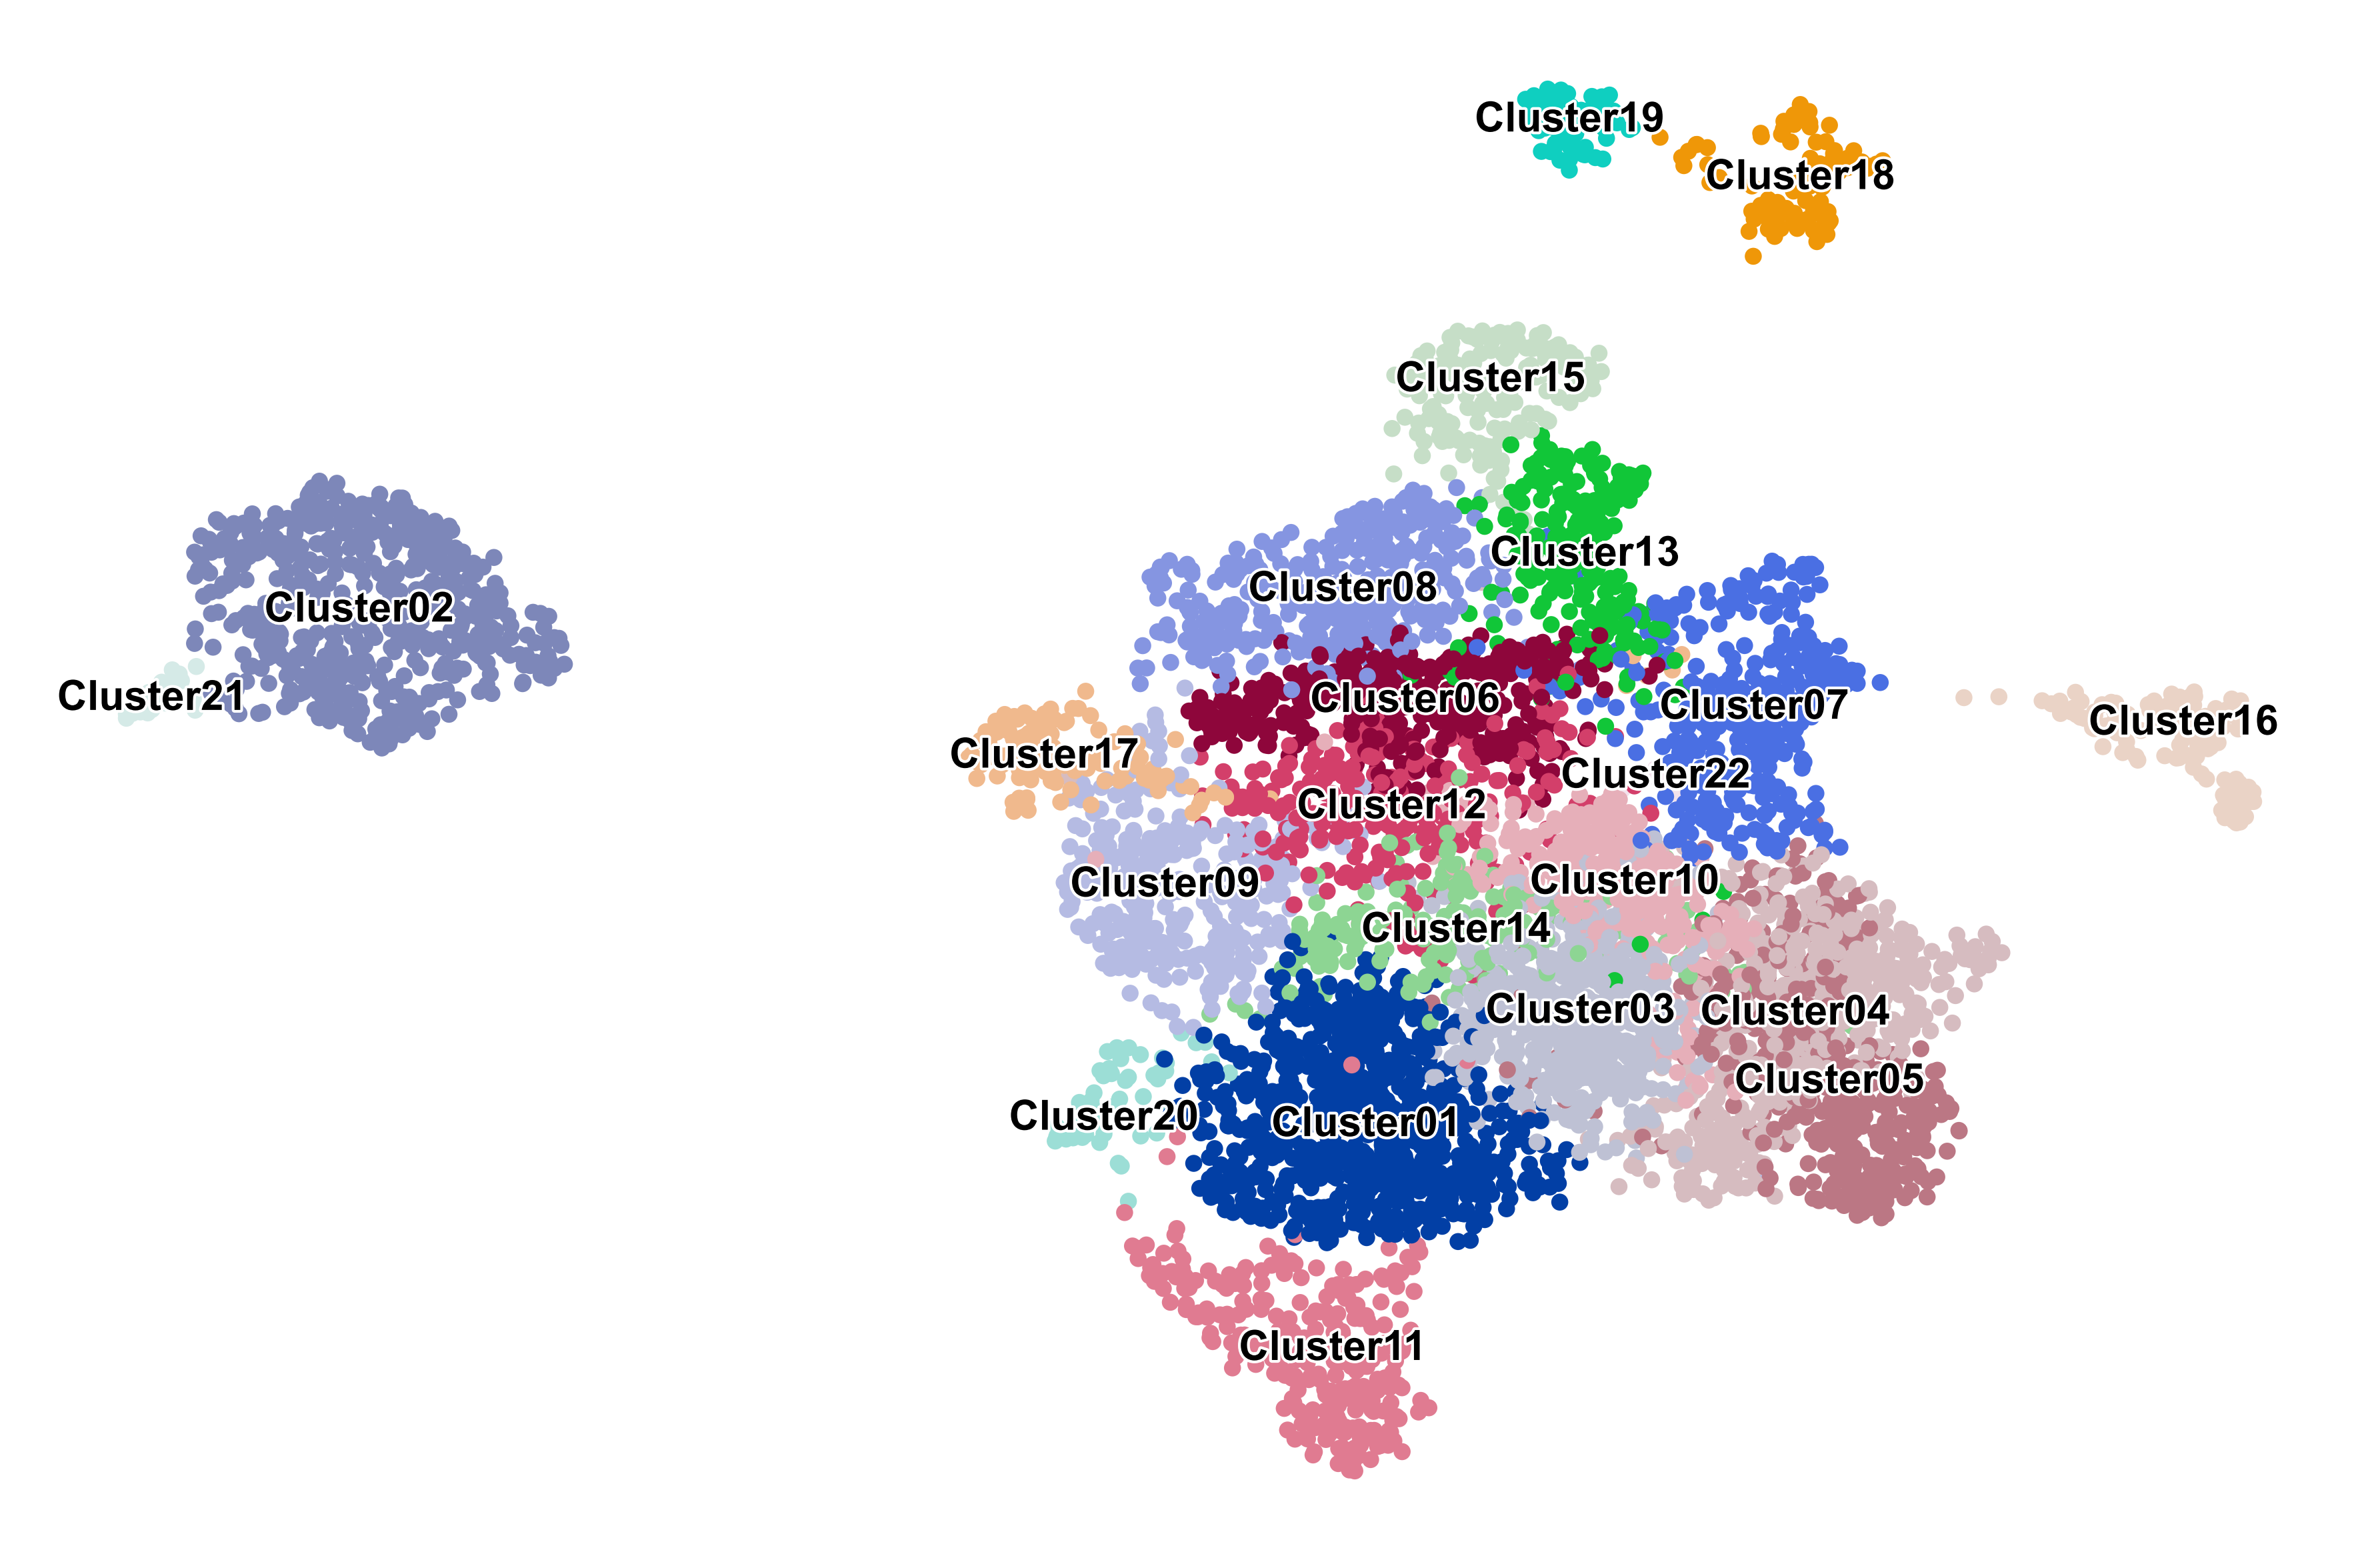

<Figure size 2250x1500 with 0 Axes>

In [21]:
plt.rcParams["figure.figsize"] = (15,10)
sc.pl.umap(adata, s=150, color='leiden', legend_loc='on data', title='', frameon=False,
           legend_fontsize=15, legend_fontoutline=2)
plt.tight_layout(); plt.savefig("./figures/03c.Clusters_leiden.png", bbox_inches="tight")

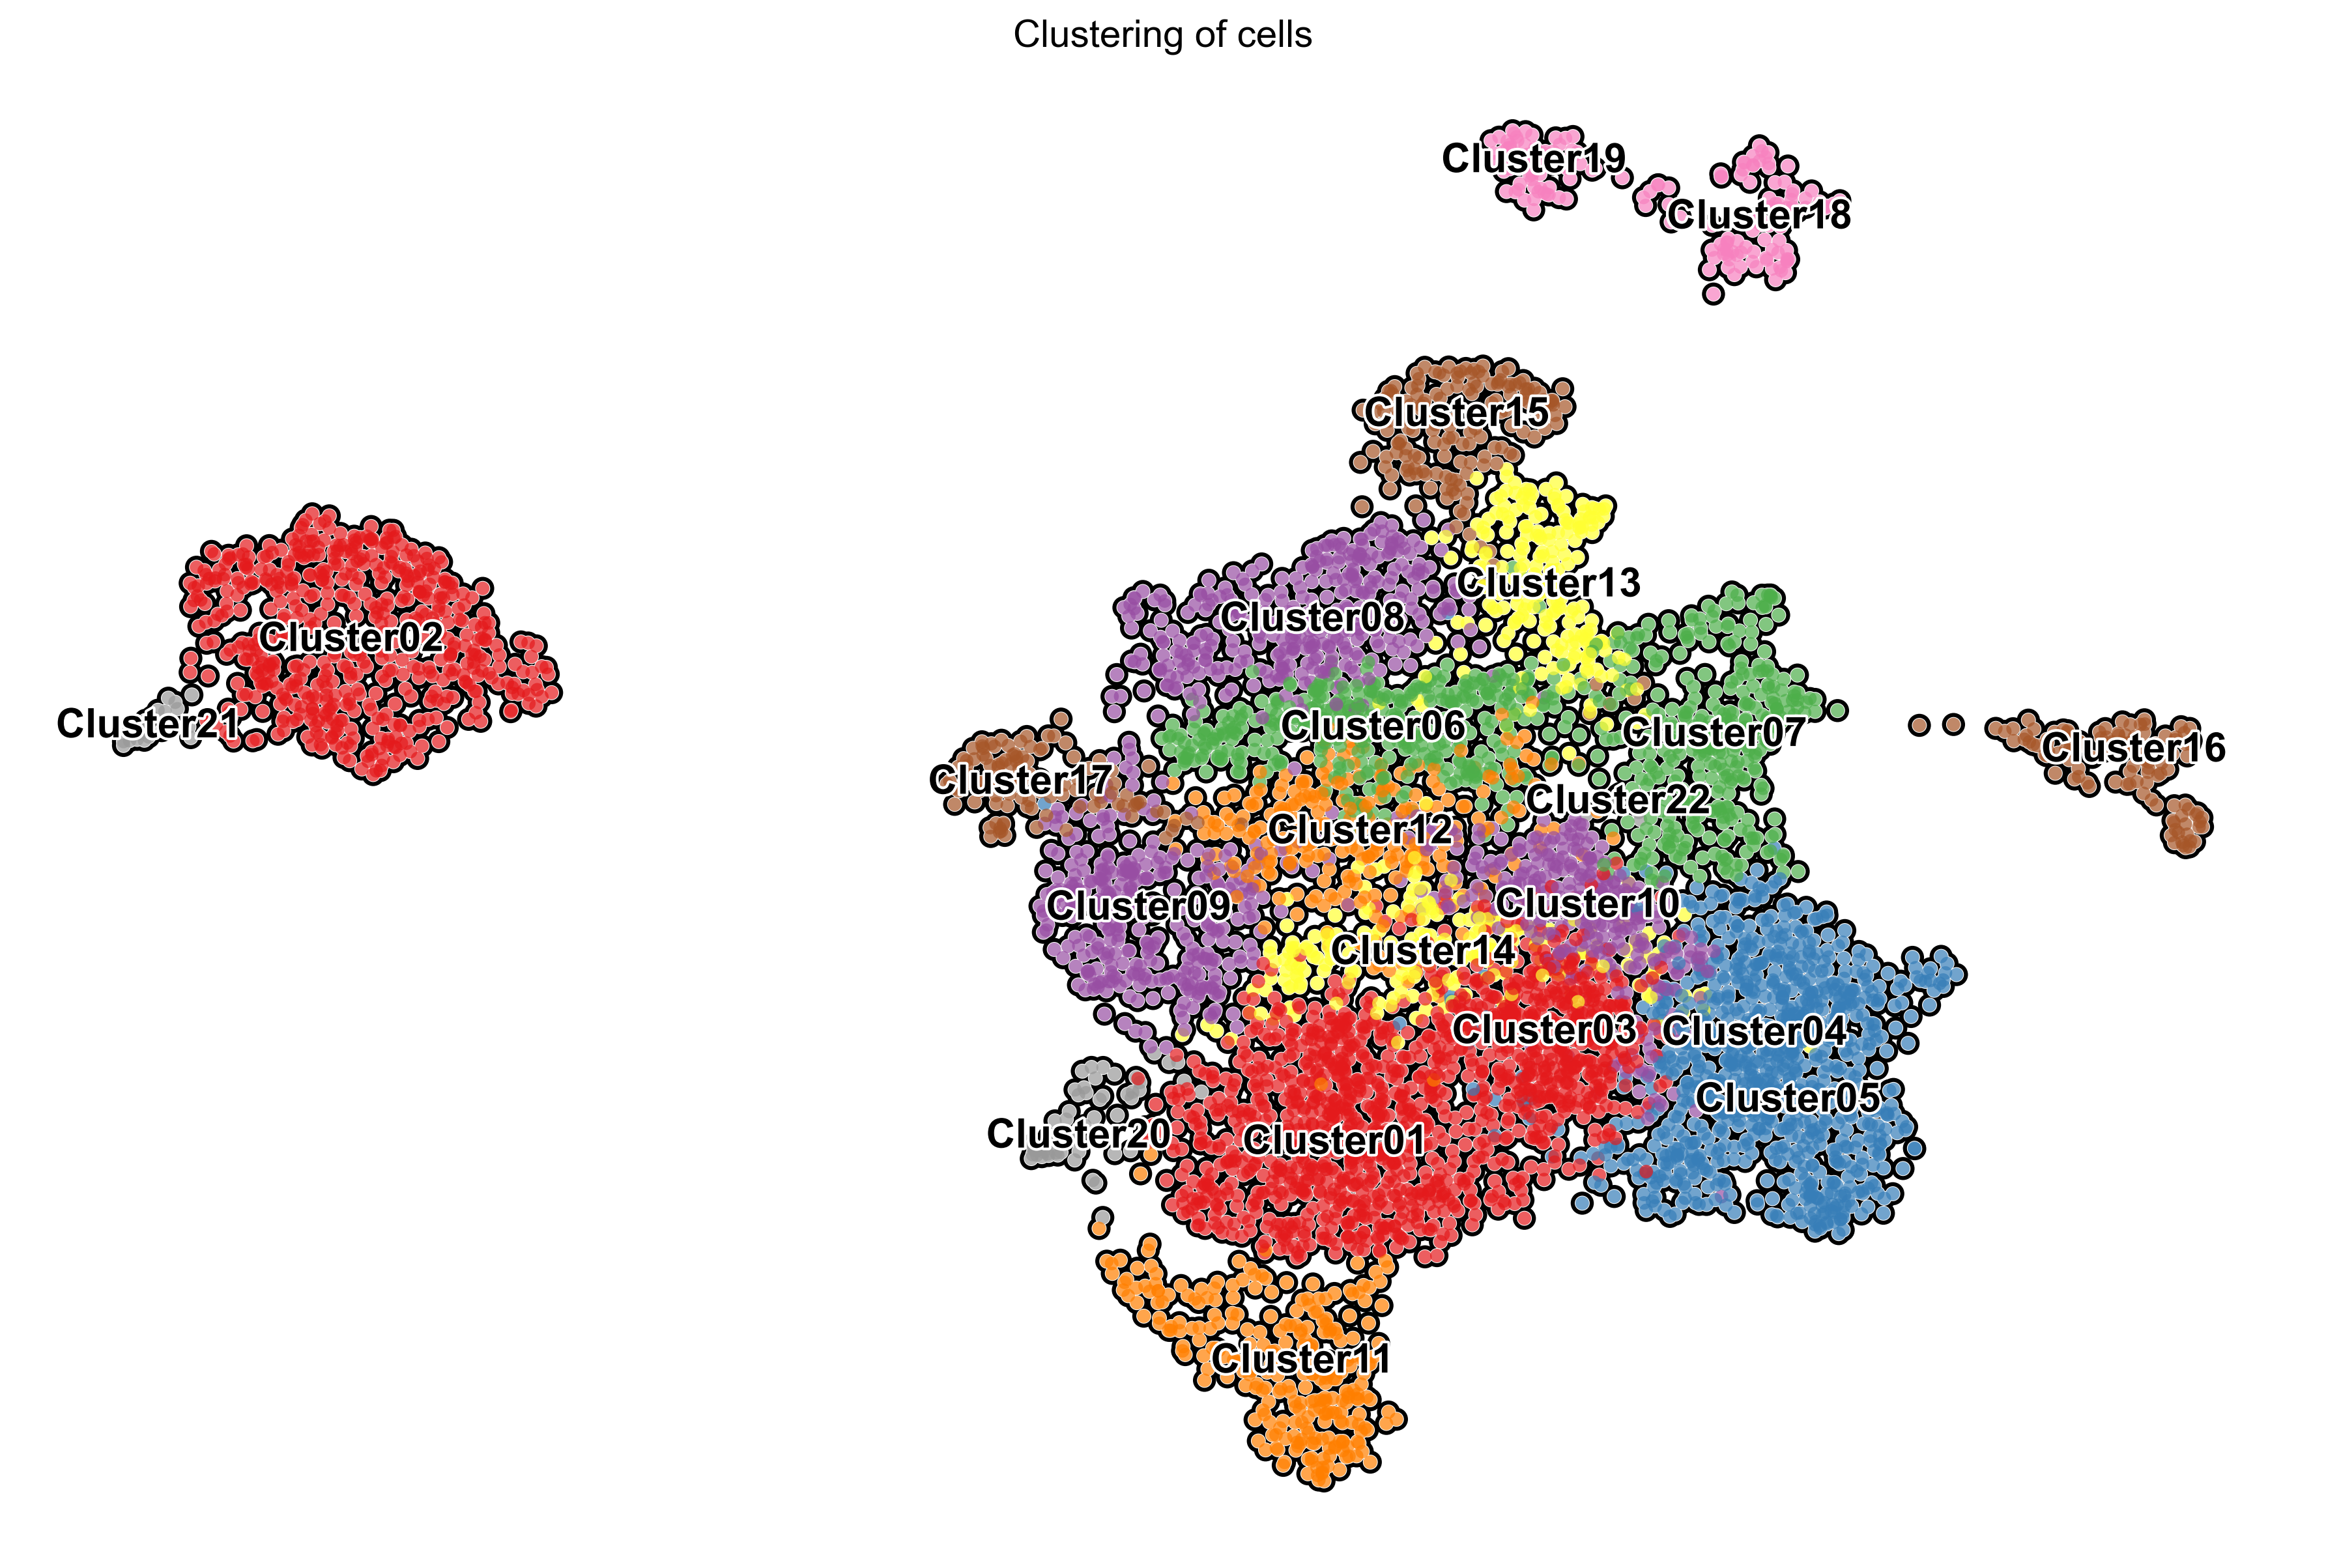

<Figure size 2250x1500 with 0 Axes>

In [22]:
with rc_context({'figure.figsize': (15, 10)}):
    sc.pl.umap(adata, color='leiden', s=100, add_outline=True, legend_loc='on data', legend_fontsize=15,
               legend_fontoutline=2, frameon=False, title='Clustering of cells', palette='Set1')
    plt.tight_layout(); plt.savefig("./figures/03d.Clusters_leiden.png", bbox_inches="tight")

In [23]:
print('Script run time:', f'{time.time()-start:.0f}', 'seconds.')

Script run time: 34 seconds.


In [24]:
print("'03_RankingGenes.v001' script run time:", f'{time.time()-start:.0f}', "seconds.")

'03_RankingGenes.v001' script run time: 34 seconds.
